<a href="https://colab.research.google.com/github/rodrigo103/AprendizajeAutomatico/blob/main/TP1_regresi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Librerías de análisis de datos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas.api.types import CategoricalDtype

from pandas.plotting import scatter_matrix

from pprint import pprint

In [18]:
# Librerías de Machine Learning

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier

ImportError: ignored

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("drive/MyDrive/AprendizajeAutomatico/OnlineNewsPopularity.csv", sep=', ')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [6]:
features = [
    'timedelta', 
    # Words
    'n_tokens_title', 'n_tokens_content', 
    'average_token_length', 
    'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
    'num_hrefs', 'num_self_hrefs',
    # Digital Media
    'num_imgs', 'num_videos', 
    # Links
    'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 
    # Time
    'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 
    'is_weekend', 
    # Keywords
    'num_keywords', 
    'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 
    'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 
    # Natural Language Processing
    'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 
    'global_subjectivity', 'global_sentiment_polarity', 
    'global_rate_positive_words', 'global_rate_negative_words', 
    'rate_positive_words', 'rate_negative_words', 
    'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 
    'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 
    'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity'
]

# Se separa el dataframe en features (X) y target (y)
X = df[features]
y = df.shares


# Lo primero que hay que hacer es separar un conjunto de datos para test
trainval_X, test_X, trainval_y, test_y = train_test_split(X, y, random_state = 0, test_size = 0.3)

# Ahora separo el conjunto de datos restante (trainval) en entrenamiento (train) y validación (val)
train_X, val_X, train_y, val_y = train_test_split(trainval_X, trainval_y, random_state = 0)

Relizo un entrenamiento con varios modelos sobre todas las features para establecer una linea de base

In [7]:
scoring = {
    'neg_mean_absolute_error', 'neg_root_mean_squared_error'
}

preprocessor = ColumnTransformer(
    [
      ('power_transformer', PowerTransformer(), 
        [
          'num_hrefs',
          'num_self_hrefs',
          'n_tokens_content',
          'self_reference_min_shares', 
          'self_reference_max_shares', 
          'self_reference_avg_sharess',
        ]
      ),
      ('standard_scaler', StandardScaler(), 
        [
          # 'n_tokens_title',
          'global_subjectivity', 
          'global_sentiment_polarity',
          'global_rate_positive_words', 
          'global_rate_negative_words',
          'rate_positive_words',
          'rate_negative_words',
          'avg_positive_polarity'
        ]
      ),
    ], remainder='passthrough')

In [ ]:
params = {
  'model__max_leaf_nodes': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 500, 5000],
  'model__random_state': [1]
}

model = DecisionTreeRegressor()

my_pipeline = Pipeline(steps=[ 
    ('standard_scaler', preprocessor),
    ('model', model)])

grid_pipeline = GridSearchCV(my_pipeline, 
                              params,
                              cv = 5, 
                              scoring = scoring,
                              refit='neg_mean_absolute_error',
                              return_train_score=True)

grid_pipeline.fit(train_X, train_y);


# Muestro resultados
print(grid_pipeline.cv_results_.keys())

print(grid_pipeline.cv_results_['param_model__max_leaf_nodes'].data)

print(grid_pipeline.cv_results_["mean_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_test_neg_root_mean_squared_error"][grid_pipeline.best_index_])

print(grid_pipeline.cv_results_["mean_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_train_neg_root_mean_squared_error"][grid_pipeline.best_index_])

best_params_decision_tree = grid_pipeline.best_params_
print(f'Best parameters {best_params_decision_tree}')
print(f'Best score {grid_pipeline.best_score_}')

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__max_leaf_nodes', 'param_model__random_state', 'params', 'split0_test_neg_root_mean_squared_error', 'split1_test_neg_root_mean_squared_error', 'split2_test_neg_root_mean_squared_error', 'split3_test_neg_root_mean_squared_error', 'split4_test_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'std_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error', 'split0_train_neg_root_mean_squared_error', 'split1_train_neg_root_mean_squared_error', 'split2_train_neg_root_mean_squared_error', 'split3_train_neg_root_mean_squared_error', 'split4_train_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error', 'std_train_neg_root_mean_squared_error', 'split0_test_neg_mean_absolute_error', 'split1_test_neg_mean_absolute_error', 'split2_test_neg_mean_absolute_error', 'split3_test_neg_mean_absolute_error', 'split4_test_neg_mean_absolute_error', 'mean_test_neg

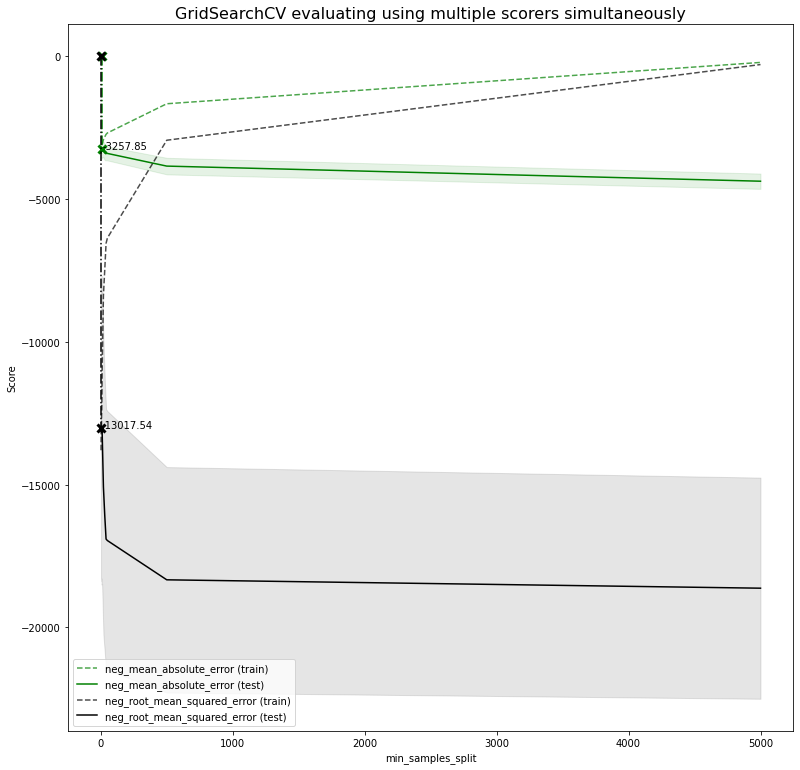

In [ ]:
results = grid_pipeline.cv_results_

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
# ax.set_xlim(0, 550)
# ax.set_ylim(-5000, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_model__max_leaf_nodes"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [ ]:
params = {
  'model__n_estimators': [
      3,
      # 5, 10, 15, 
      # 50, 100, 200
      ],
  # 'model__max_depth': [7],
  'model__random_state': [1], 
}

model = RandomForestRegressor()

my_pipeline = Pipeline(steps=[ 
    ('standard_scaler', preprocessor),
    ('model', model)])

grid_pipeline = GridSearchCV(my_pipeline,
                              params,
                              cv = 5,
                              scoring = scoring,
                              refit='neg_mean_absolute_error',
                              return_train_score=True)

grid_pipeline.fit(train_X, train_y);


# Muestro resultados
print(grid_pipeline.cv_results_.keys())

print(grid_pipeline.cv_results_['param_model__n_estimators'].data)

print(grid_pipeline.cv_results_["mean_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_test_neg_root_mean_squared_error"][grid_pipeline.best_index_])

print(grid_pipeline.cv_results_["mean_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_train_neg_root_mean_squared_error"][grid_pipeline.best_index_])

best_params_random_forest = grid_pipeline.best_params_
print(f'Best parameters {best_params_random_forest}')
print(f'Best score {grid_pipeline.best_score_}')

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__n_estimators', 'param_model__random_state', 'params', 'split0_test_neg_mean_absolute_error', 'split1_test_neg_mean_absolute_error', 'split2_test_neg_mean_absolute_error', 'split3_test_neg_mean_absolute_error', 'split4_test_neg_mean_absolute_error', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'split0_train_neg_mean_absolute_error', 'split1_train_neg_mean_absolute_error', 'split2_train_neg_mean_absolute_error', 'split3_train_neg_mean_absolute_error', 'split4_train_neg_mean_absolute_error', 'mean_train_neg_mean_absolute_error', 'std_train_neg_mean_absolute_error', 'split0_test_neg_root_mean_squared_error', 'split1_test_neg_root_mean_squared_error', 'split2_test_neg_root_mean_squared_error', 'split3_test_neg_root_mean_squared_error', 'split4_test_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'std_test_neg_r

In [8]:
params = {
  'model__n_estimators': [
      5, 10, 15, 
      # 20, 25, 50, 100, 
      # 500, 
      # 1000
      ],
  'model__learning_rate': [0.01, 0.05, 0.1],
  'model__early_stopping_rounds':[5],
  'model__random_state': [1], 
}

model = XGBRegressor()

my_pipeline = Pipeline(steps=[ 
    ('standard_scaler', preprocessor),
    ('model', model)])

grid_pipeline = GridSearchCV(my_pipeline, 
                              params, 
                              cv = 5, 
                              scoring = scoring,
                              refit='neg_mean_absolute_error',
                              return_train_score=True)

grid_pipeline.fit(train_X, train_y);


# Muestro resultados
print(grid_pipeline.cv_results_.keys())

print(grid_pipeline.cv_results_['param_model__n_estimators'].data)

print(grid_pipeline.cv_results_["mean_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_test_neg_root_mean_squared_error"][grid_pipeline.best_index_])

print(grid_pipeline.cv_results_["mean_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_train_neg_root_mean_squared_error"][grid_pipeline.best_index_])

best_params_xgb = grid_pipeline.best_params_
print(f'Best parameters {best_params_xgb}')
print(f'Best score {grid_pipeline.best_score_}')

[01:59:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

El rendimiento del mejor modelo tomando en cuenta la variable MAE antes de recortar las variables fue con XGBRegressor y fue de  
MAE: -2558.988310039436 MSE: -13090.501674452278
con los parámetros:  
'model__early_stopping_rounds': 5,  
'model__learning_rate': 0.1,  
'model__n_estimators': 5,  
'model__random_state': 1 


## Ahora voy a hacer un último fit y predict con el conjunto de test para calcular las metricas finales.

In [41]:
print(best_params_xgb)

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=5,
        learning_rate=0.1,
        random_state=1,
        ))
  ])

my_pipeline.fit(trainval_X, trainval_y)

preds = my_pipeline.predict(test_X)

print(f"MAE: {mean_absolute_error(preds, test_y)} MSE: {np.sqrt(mean_squared_error(preds, test_y))}" )

{'model__early_stopping_rounds': 5, 'model__learning_rate': 0.1, 'model__n_estimators': 5, 'model__random_state': 1}
[02:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 2335.098479300923 MSE: 8411.33974283846


El resultado final fue: MAE: 2335.098479300923 MSE: 8411.33974283846

## Vuelvo a correr los modelos despreciando algunos features de acuerdo al análisis EDA

In [43]:
features = [
    # 'timedelta', 
    # Words
    'n_tokens_title', 'n_tokens_content', 
    # 'average_token_length', 
    # 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
    'num_hrefs', 'num_self_hrefs',
    # Digital Media
    # 'num_imgs', 'num_videos', 
    # Links
    'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 
    # Time
    # 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 
    # 'is_weekend', 
    # Keywords
    'num_keywords', 
    'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 
    'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 
    # Natural Language Processing
    'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 
    'global_subjectivity', 'global_sentiment_polarity', 
    'global_rate_positive_words', 'global_rate_negative_words', 
    'rate_positive_words', 'rate_negative_words', 
    'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 
    'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 
    'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity'
]

# Se separa el dataframe en features (X) y target (y)
X = df[features]
y = df.shares

# Lo primero que hay que hacer es separar un conjunto de datos para test
trainval_X, test_X, trainval_y, test_y = train_test_split(X, y, random_state = 0, test_size = 0.3)

# Ahora separo el conjunto de datos restante (trainval) en entrenamiento (train) y validación (val)
train_X, val_X, train_y, val_y = train_test_split(trainval_X, trainval_y, random_state = 0)

Vuelvo a probar XGBRegressor con menos features

In [44]:
params = {
  'model__n_estimators': [
      5, 10, 15, 
      # 20, 25, 50, 100, 
      # 500, 
      # 1000
      ],
  'model__learning_rate': [0.01, 0.05, 0.1],
  'model__early_stopping_rounds':[5],
  'model__random_state': [1], 
}

model = XGBRegressor()

my_pipeline = Pipeline(steps=[ 
    ('standard_scaler', preprocessor),
    ('model', model)])

grid_pipeline = GridSearchCV(my_pipeline, 
                              params, 
                              cv = 5, 
                              scoring = scoring,
                              refit='neg_mean_absolute_error',
                              return_train_score=True)

grid_pipeline.fit(train_X, train_y);


# Muestro resultados
print(grid_pipeline.cv_results_.keys())

print(grid_pipeline.cv_results_['param_model__n_estimators'].data)

print(grid_pipeline.cv_results_["mean_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_test_neg_root_mean_squared_error"][grid_pipeline.best_index_])

print(grid_pipeline.cv_results_["mean_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_train_neg_root_mean_squared_error"][grid_pipeline.best_index_])

best_params_xgb = grid_pipeline.best_params_
print(f'Best parameters {best_params_xgb}')
print(f'Best score {grid_pipeline.best_score_}')

[02:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

El resultado fue ligeramente peor que con todas las features.